In [1]:
import vtk
from vtk import vtkXMLUnstructuredGridReader
from vtk.util.numpy_support import vtk_to_numpy
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.spatial import KDTree
import pygmt
import pandas as pd

os.chdir("../postprocessing_scripts/")
import parallel_curves
import slab_hydration

os.chdir("../main_figures/")

In [3]:
def cartesian_to_spherical(x, y, z):
    """
    Takes an x, y, z and converts it to spherical coordinates. Returns r, theta, phi
    """
    r = np.sqrt(x**2 + y**2 + z**2)
    theta = 90 - np.rad2deg( np.arccos( z / (np.sqrt(x**2 + y**2 + z**2)) ) )
    phi =  np.sign(y) * np.rad2deg(np.arccos( x / np.sqrt(x**2 + y**2) ))
    phi[np.where(phi < 0)] = phi[np.where(phi < 0)] + 360
    phi[np.where(phi == 0)] = 180
    
    return r, phi, theta

def spherical_to_global_cartesian(r, phi, theta):
    """
    Takes spherical coordinates r, theta, and phi and converts to Cartesian coordinates.
    Returns x, y, z
    """
    x = r * np.sin(np.deg2rad(90 - theta)) * np.cos(np.deg2rad(phi))
    y = r * np.sin(np.deg2rad(90 - theta)) * np.sin(np.deg2rad(phi))
    z = r * np.cos(np.deg2rad(90 - theta))
    
    return x, y, z

## This cell loads in the ASPECT output

In [4]:
sol_dir_path = "../ASPECT_models/5e20_10kmweak_dry/solution/"

solutions = np.sort(os.listdir( sol_dir_path ))

t_step = 0
pos_solution = np.empty(0)
litho_total = np.empty(0)
crust_total = np.empty(0)
mantle_total = np.empty(0)
T_raw_total = np.empty(0)
P_raw_total = np.empty(0)
TVZ_total = np.empty(0)
interface_total = np.empty(0)
east_aus_total = np.empty(0)
overriding_total = np.empty(0)
velocity_total = np.empty(0)

for soln in solutions:
    if soln[-4:-1] == '.vt' and soln[9:14] == str(t_step).zfill(5):
        
        file_path = os.path.join(sol_dir_path, soln)
        reader = vtkXMLUnstructuredGridReader()
        reader.SetFileName(file_path)
        reader.Update()
        data = reader.GetOutput()
        points = data.GetPoints()
        x = vtk_to_numpy(points.GetData())
        litho = vtk_to_numpy(data.GetPointData().GetArray('Base_Subducting'))
        mantle = vtk_to_numpy(data.GetPointData().GetArray('Upper_Mantle'))
        interface = vtk_to_numpy(data.GetPointData().GetArray('plastic_strain'))
        east_aus = vtk_to_numpy(data.GetPointData().GetArray('East_Prov_AUS'))
        overriding = vtk_to_numpy(data.GetPointData().GetArray('Base_Continent'))
        crust = vtk_to_numpy(data.GetPointData().GetArray('Crust'))
        TVZ = vtk_to_numpy(data.GetPointData().GetArray('TVZ'))
        T_raw = vtk_to_numpy(data.GetPointData().GetArray('T'))
        P_raw = vtk_to_numpy(data.GetPointData().GetArray('p'))

        if len(pos_solution) == 0 :
            pos_solution = x
        else:
            pos_solution = np.concatenate( (pos_solution, x) )
        litho_total = np.concatenate( (litho_total, litho) )
        mantle_total = np.concatenate( (mantle_total, mantle) )
        interface_total = np.concatenate( (interface_total, interface) )
        overriding_total = np.concatenate( (overriding_total, overriding) )
        east_aus_total = np.concatenate( (east_aus_total, east_aus) )
        TVZ_total = np.concatenate( (TVZ_total, TVZ) )
        T_raw_total = np.concatenate( (T_raw_total, T_raw) )
        P_raw_total = np.concatenate( (P_raw_total, P_raw) )
        crust_total = np.concatenate( (crust_total, crust) )
            
field_solution = np.array([litho_total, crust_total, T_raw_total, P_raw_total, TVZ_total], dtype=object)

tree_unstructured = KDTree(np.c_[pos_solution[:, 0], pos_solution[:, 1], pos_solution[:, 2]])

slab_indices = np.where( (litho_total >= 0.5) | (crust_total >= 0.5) )
mantle_indices = np.where( (mantle_total >= 0.5) | (interface_total >= 0.5) | (east_aus_total >= 0.5) | (TVZ_total >= 0.5) | (overriding_total >= 0.5) )
slab_x = pos_solution[:, 0][slab_indices]
slab_y = pos_solution[:, 1][slab_indices]
slab_z = pos_solution[:, 2][slab_indices]
slab_P = P_raw_total[slab_indices]
slab_T = T_raw_total[slab_indices]
ASPECT_slab_r, ASPECT_slab_phi, ASPECT_slab_theta = cartesian_to_spherical(slab_x, slab_y, slab_z)

mantle_x = pos_solution[:, 0][mantle_indices]
mantle_y = pos_solution[:, 1][mantle_indices]
mantle_z = pos_solution[:, 2][mantle_indices]
mantle_P = P_raw_total[mantle_indices]
mantle_T = T_raw_total[mantle_indices]
ASPECT_UM_r, ASPECT_UM_phi, ASPECT_UM_theta = cartesian_to_spherical(mantle_x, mantle_y, mantle_z)

slabtree_unstructured = KDTree(np.c_[slab_x, slab_y, slab_z])
UM_tree = KDTree(np.c_[pos_solution[:, 0][mantle_indices], pos_solution[:, 1][mantle_indices], pos_solution[:, 2][mantle_indices]])

## This cell takes a 2D slice out of the moel and interpolates ASPECT fields onto it

In [5]:
cutoff_distance = 3.5e3
radius_array = np.linspace(6371e3, 5871e3, 401)
base_depth = 0

lon_lat_slice = np.array([[179.57, -38.2], \
                          [175.27, -36.7]])

profile = pygmt.project(center=[lon_lat_slice[0][0], lon_lat_slice[0][1]], endpoint=[lon_lat_slice[1][0], lon_lat_slice[1][1]], generate=1e3/1e3, unit=True).to_numpy()
prof_lon = profile[:, 0]
prof_lat = profile[:, 1]
prof_dist = profile[:, 2]
prof_lon[np.where(prof_lon < 0)] = prof_lon[np.where(prof_lon < 0)] + 360
prof_lon[np.where(prof_lon == 0)] = 180

slab_top_depth = np.empty(0)
slab_top_dist = np.empty(0)

slab_depth_vals = np.empty(0)
slab_dist_vals = np.empty(0)
slab_T_vals = np.empty(0)
slab_P_vals = np.empty(0)

UM_depth_vals = np.empty(0)
UM_dist_vals = np.empty(0)
UM_T_vals = np.empty(0)
UM_P_vals = np.empty(0)

for i in range(len(prof_lon)):
    reached_surface = False
    for j in range(len(radius_array)):              
        prof_x, prof_y, prof_z = spherical_to_global_cartesian(radius_array[j], prof_lon[i], prof_lat[i])

        dd, slab_idx = slabtree_unstructured.query([prof_x, prof_y, prof_z], k=1)
        dd_UM, UM_idx = UM_tree.query([prof_x, prof_y, prof_z], k=1)
        if dd <= cutoff_distance:
            if not reached_surface:
                slab_top_dist = np.append(slab_top_dist, prof_dist[i])
                slab_top_depth = np.append(slab_top_depth, (6371e3 - ASPECT_slab_r[slab_idx]) / 1e3 )
                reached_surface = True                  

            slab_dist_vals = np.append(slab_dist_vals, prof_dist[i])
            slab_depth_vals = np.append(slab_depth_vals, (6371e3 - ASPECT_slab_r[slab_idx]) / 1e3 )
            slab_T_vals = np.append(slab_T_vals, slab_T[slab_idx])
            slab_P_vals = np.append(slab_P_vals, slab_P[slab_idx])
            
        if dd_UM <= cutoff_distance:
            UM_dist_vals = np.append(UM_dist_vals, prof_dist[i])
            UM_depth_vals = np.append(UM_depth_vals, (6371e3 - ASPECT_UM_r[UM_idx]) / 1e3 )
            UM_T_vals = np.append(UM_T_vals, mantle_T[UM_idx])
            UM_P_vals = np.append(UM_P_vals, mantle_P[UM_idx])

UM_slab_top_dist = np.empty(0)
UM_slab_top_depth = np.empty(0)
UM_slab_top_T = np.empty(0)
UM_slab_top_P = np.empty(0)
for i in range(len(slab_top_dist)):
    dist_ind = np.where(UM_dist_vals == slab_top_dist[i])
    for j in range(len(dist_ind[0])):
        if UM_depth_vals[dist_ind[0][j]] < slab_top_depth[i]:
            UM_slab_top_dist = np.append(UM_slab_top_dist, UM_dist_vals[dist_ind[0][j]])
            UM_slab_top_depth = np.append(UM_slab_top_depth, UM_depth_vals[dist_ind[0][j]])
            UM_slab_top_T = np.append(UM_slab_top_T, UM_T_vals[dist_ind[0][j]])
            UM_slab_top_P = np.append(UM_slab_top_P, UM_P_vals[dist_ind[0][j]])   

In [8]:
H2O_LR_poly_sediment = np.array([-2.03283, 10.8186, -21.2119, 18.3351, -6.48711, 8.32459])
H2O_c_sat_poly_sediment = np.array([-0.150662, 0.301807, 1.01867])
H2O_Td_poly_sediment = np.array([2.83277, -24.7593, 85.9090, 524.898])

sediment_density = 2300
sediment_depth_range = np.array([0, 2])
sediment_max_hydration = 3.3 / 100

H2O_LR_poly_MORB = np.array([-1.78177, 7.50871, -10.4840, 5.19725, 7.96365])
H2O_c_sat_poly_MORB = np.array([0.0102725, -0.115390, 0.324452, 1.41588])
H2O_Td_poly_MORB = np.array([-3.81280, 22.7809, 638.049])

MORB_density = 2900
MORB_depth_range = np.array([2, 6])
MORB_max_hydration = 3.0 / 100

H2O_LR_poly_gabbro = np.array([-1.81745, 7.67198, -10.8507, 5.09329, 8.14519])
H2O_c_sat_poly_gabbro = np.array([-0.0176673, 0.0893044, 1.52732])
H2O_Td_poly_gabbro = np.array([-1.72277, 20.5898, 637.517])

gabbro_density = 3000
gabbro_depth_range = np.array([6, 11])
gabbro_max_hydration = 0.8 / 100

H2O_LR_poly_peridotite = np.array([-19.0609, 168.983, -630.032, 1281.84, -1543.14, 1111.88, -459.142, 95.4143, 1.97246])
H2O_c_sat_poly_peridotite = np.array([0.00115628, 2.42179])
H2O_Td_poly_peridotite = np.array([-15.4627, 94.9716, 636.603])

peridotite_density = 3300
peridotite_depth_range = np.array([11, 16])
peridotite_max_hydration = 2 / 100

if prof_lat[0] >= -36:
    sediment_depth_range = np.array([0, 2])
    MORB_depth_range = np.array([2, 5])
    gabbro_depth_range = np.array([5, 9])
    peridotite_depth_range = np.array([9, 16])

all_lat_points = np.empty(0)
all_lon_points = np.empty(0)
all_flux_points = np.empty(0)
all_sediment_points = np.empty(0)
all_MORB_points = np.empty(0)
all_gabbro_points = np.empty(0)
all_peridotite_points = np.empty(0)

litho_thickness = 16
line_spacing = 0.25
number_of_lines = int(litho_thickness / line_spacing)
parallel_slab_dist = np.zeros(number_of_lines, dtype=object)
parallel_slab_depth = np.zeros(number_of_lines, dtype=object)

# Interpolate the slab-top points to make a smooth curve
p_coeff = np.polyfit(slab_top_dist, slab_top_depth, 5)
full_interp_slab_top = 0
interp_dxy = 0.25
full_interp_slab_dist = np.arange(np.min(slab_top_dist), np.max(slab_top_dist) + interp_dxy, interp_dxy)
for p in range(len(p_coeff)):
    full_interp_slab_top += p_coeff[p] * full_interp_slab_dist**(len(p_coeff) - 1 - p)

# Draw parallel lines to the slab top curve
for i in range(number_of_lines):
    res = parallel_curves.parallel_curves(full_interp_slab_dist, full_interp_slab_top, d=base_depth + line_spacing * (i), make_plot=False, flag1=False)
    parallel_slab_dist[i] = res['x_inner']
    parallel_slab_depth[i] = res['y_inner']

# Create a KDTree of the slab points in the profile
slab_tree = KDTree(np.c_[slab_dist_vals, slab_depth_vals])

profile_pressure = np.zeros(len(parallel_slab_dist), dtype=object)
profile_temperature = np.zeros(len(parallel_slab_dist), dtype=object)

# Extract the slab P-T along each of the parallel profiles
for i in range(len(parallel_slab_dist)):
    profile_pressure[i] = np.zeros(len(parallel_slab_dist[i]))
    profile_temperature[i] = np.zeros(len(parallel_slab_dist[i]))

    for j in range(len(parallel_slab_dist[i])):
        dd, ii = slab_tree.query([parallel_slab_dist[i][j], parallel_slab_depth[i][j]], k=1)
        profile_pressure[i][j] = slab_P_vals[ii]
        profile_temperature[i][j] = slab_T_vals[ii]

# Calculate the water content and dehydration along each profile
hydration_container = np.zeros(number_of_lines, dtype=object)
dehydration_container = np.zeros(number_of_lines, dtype=object)

sediment_hydration = np.zeros(number_of_lines, dtype=object)
sediment_dehydration = np.zeros(number_of_lines, dtype=object)

gabbro_hydration = np.zeros(number_of_lines, dtype=object)
gabbro_dehydration = np.zeros(number_of_lines, dtype=object)

MORB_hydration = np.zeros(number_of_lines, dtype=object)
MORB_dehydration= np.zeros(number_of_lines, dtype=object)

peridotite_hydration = np.zeros(number_of_lines, dtype=object)
peridotite_dehydration = np.zeros(number_of_lines, dtype=object)
############################################################### SEDIMENTS ##########################################################################
hydration_container, dehydration_container = slab_hydration.dehydration_func(H2O_LR_poly_sediment, H2O_c_sat_poly_sediment, H2O_Td_poly_sediment, \
                                                                             sediment_density, profile_pressure, profile_temperature, \
                                                                             sediment_max_hydration, hydration_container, dehydration_container, \
                                                                             parallel_slab_dist, sediment_depth_range, line_spacing, sediment=True)

sediment_hydration, sediment_dehydration = slab_hydration.dehydration_func(H2O_LR_poly_sediment, H2O_c_sat_poly_sediment, H2O_Td_poly_sediment, \
                                                                           sediment_density, profile_pressure, profile_temperature, \
                                                                           sediment_max_hydration, sediment_hydration, sediment_dehydration, \
                                                                           parallel_slab_dist, sediment_depth_range, line_spacing, sediment=True)
############################################################### MORB ##########################################################################
hydration_container, dehydration_container = slab_hydration.dehydration_func(H2O_LR_poly_MORB, H2O_c_sat_poly_MORB, H2O_Td_poly_MORB, \
                                                                             MORB_density, profile_pressure, profile_temperature, \
                                                                             MORB_max_hydration, hydration_container, dehydration_container, \
                                                                             parallel_slab_dist, MORB_depth_range, line_spacing, sediment=False)

MORB_hydration, MORB_dehydration = slab_hydration.dehydration_func(H2O_LR_poly_MORB, H2O_c_sat_poly_MORB, H2O_Td_poly_MORB, \
                                                                   MORB_density, profile_pressure, profile_temperature, \
                                                                   MORB_max_hydration, MORB_hydration, MORB_dehydration, \
                                                                   parallel_slab_dist, MORB_depth_range, line_spacing, sediment=False)
############################################################### GABBRO ##########################################################################
hydration_container, dehydration_container = slab_hydration.dehydration_func(H2O_LR_poly_gabbro, H2O_c_sat_poly_gabbro, H2O_Td_poly_gabbro, \
                                                                             gabbro_density, profile_pressure, profile_temperature, \
                                                                             gabbro_max_hydration, hydration_container, dehydration_container, \
                                                                             parallel_slab_dist, gabbro_depth_range, line_spacing, sediment=False)

gabbro_hydration, gabbro_dehydration = slab_hydration.dehydration_func(H2O_LR_poly_gabbro, H2O_c_sat_poly_gabbro, H2O_Td_poly_gabbro, \
                                                                       gabbro_density, profile_pressure, profile_temperature, \
                                                                       gabbro_max_hydration, gabbro_hydration, gabbro_dehydration, \
                                                                       parallel_slab_dist, gabbro_depth_range, line_spacing, sediment=False)
############################################################### PERIDOTITE ##########################################################################
hydration_container, dehydration_container = slab_hydration.dehydration_func(H2O_LR_poly_peridotite, H2O_c_sat_poly_peridotite, H2O_Td_poly_peridotite, \
                                                                             peridotite_density, profile_pressure, profile_temperature, \
                                                                             peridotite_max_hydration, hydration_container, dehydration_container, \
                                                                             parallel_slab_dist, peridotite_depth_range, line_spacing, sediment=False)

peridotite_hydration, peridotite_dehydration = slab_hydration.dehydration_func(H2O_LR_poly_peridotite, H2O_c_sat_poly_peridotite, H2O_Td_poly_peridotite, \
                                                                               peridotite_density, profile_pressure, profile_temperature, \
                                                                               peridotite_max_hydration, peridotite_hydration, peridotite_dehydration, \
                                                                               parallel_slab_dist, peridotite_depth_range, line_spacing, sediment=False)
############################################################### END HYDRATION CALC ##########################################################################   

for i in range(len(sediment_hydration)):
    if np.any(sediment_hydration[i]):
        sediment_hydration[i] = sediment_hydration[i]
        sediment_dehydration[i] = sediment_dehydration[i]
    else:
        sediment_hydration[i] = np.zeros(len(parallel_slab_dist[0]))
        sediment_dehydration[i] = np.zeros(len(parallel_slab_dist[0]))

for i in range(len(gabbro_hydration)):
    if np.any(gabbro_hydration[i]):
        gabbro_hydration[i] = gabbro_hydration[i]
        gabbro_dehydration[i] = gabbro_dehydration[i]
    else:
        gabbro_hydration[i] = np.zeros(len(parallel_slab_dist[0]))
        gabbro_dehydration[i] = np.zeros(len(parallel_slab_dist[0]))

for i in range(len(MORB_hydration)):
    if np.any(MORB_hydration[i]):
        MORB_hydration[i] = MORB_hydration[i]
        MORB_dehydration[i] = MORB_dehydration[i]
    else:
        MORB_hydration[i] = np.zeros(len(parallel_slab_dist[0]))
        MORB_dehydration[i] = np.zeros(len(parallel_slab_dist[0]))

for i in range(len(peridotite_hydration)):
    if np.any(peridotite_hydration[i]):
        peridotite_hydration[i] = peridotite_hydration[i]
        peridotite_dehydration[i] = peridotite_dehydration[i]
    else:
        peridotite_hydration[i] = np.zeros(len(parallel_slab_dist[0]))
        peridotite_dehydration[i] = np.zeros(len(parallel_slab_dist[0]))

# Calculate the surface water flux (vertical integration)
surface_slab_water_flux = slab_hydration.vertical_surface_water_flux(parallel_slab_dist, parallel_slab_depth, dehydration_container, line_spacing)
surface_slab_sediment_flux = slab_hydration.vertical_surface_water_flux(parallel_slab_dist, parallel_slab_depth, sediment_dehydration, line_spacing)
surface_slab_MORB_flux = slab_hydration.vertical_surface_water_flux(parallel_slab_dist, parallel_slab_depth, MORB_dehydration, line_spacing)
surface_slab_gabbro_flux = slab_hydration.vertical_surface_water_flux(parallel_slab_dist, parallel_slab_depth, gabbro_dehydration, line_spacing)
surface_slab_peridotite_flux = slab_hydration.vertical_surface_water_flux(parallel_slab_dist, parallel_slab_depth, peridotite_dehydration, line_spacing)

# Bin the flux into 10km bins
bin_size = 10
surface_slab_flux_x = np.arange(0, np.max(parallel_slab_dist[0]) + bin_size, bin_size)
bin_peridotite_slab_flux = np.zeros(len(surface_slab_flux_x))
bin_sediment_slab_flux = np.zeros(len(surface_slab_flux_x))
bin_gabbro_slab_flux = np.zeros(len(surface_slab_flux_x))
bin_MORB_slab_flux = np.zeros(len(surface_slab_flux_x))
bin_total_slab_flux = np.zeros(len(surface_slab_flux_x))
for i in range(len(surface_slab_flux_x) - 1):
    bin_index = np.where( (parallel_slab_dist[0] >= surface_slab_flux_x[i]) & (parallel_slab_dist[0] <= surface_slab_flux_x[i+1]) )
    bin_peridotite_slab_flux[i] = np.trapz(surface_slab_peridotite_flux[bin_index], dx=interp_dxy)
    bin_sediment_slab_flux[i] = np.trapz(surface_slab_sediment_flux[bin_index], dx=interp_dxy)
    bin_gabbro_slab_flux[i] = np.trapz(surface_slab_gabbro_flux[bin_index], dx=interp_dxy)
    bin_MORB_slab_flux[i] = np.trapz(surface_slab_MORB_flux[bin_index], dx=interp_dxy)
    bin_total_slab_flux[i] = np.trapz(surface_slab_water_flux[bin_index], dx=interp_dxy)

cutoff_val = 0
set_val = -100
bin_total_slab_flux[np.where(bin_total_slab_flux <= cutoff_val)] = set_val
bin_sediment_slab_flux[np.where(bin_sediment_slab_flux <= cutoff_val)] = set_val
bin_MORB_slab_flux[np.where(bin_MORB_slab_flux <= cutoff_val)] = set_val
bin_gabbro_slab_flux[np.where(bin_gabbro_slab_flux <= cutoff_val)] = set_val
bin_peridotite_slab_flux[np.where(bin_peridotite_slab_flux <= cutoff_val)] = set_val

# Create a higher resolution profile and convert the profiles back to lon/lat
highres_profile = pygmt.project(center=[lon_lat_slice[0][0], lon_lat_slice[0][1]], endpoint=[lon_lat_slice[1][0], lon_lat_slice[1][1]], generate=bin_size, unit=True).to_numpy()
highres_prof_lon = highres_profile[:, 0]
highres_prof_lat = highres_profile[:, 1]
highres_prof_dist = highres_profile[:, 2]
highres_prof_lon[np.where(highres_prof_lon < 0)] = highres_prof_lon[np.where(highres_prof_lon < 0)] + 360
highres_prof_lon[np.where(highres_prof_lon == 0)] = 180

for i in range(len(surface_slab_flux_x)):
    lonlat_index = np.abs((highres_prof_dist - surface_slab_flux_x[i])).argmin()
    all_lat_points = np.append(all_lat_points, highres_prof_lat[lonlat_index])
    all_lon_points = np.append(all_lon_points, highres_prof_lon[lonlat_index])
    all_flux_points = np.append(all_flux_points, bin_total_slab_flux[i])
    all_sediment_points = np.append(all_sediment_points, bin_sediment_slab_flux[i])
    all_MORB_points = np.append(all_MORB_points, bin_MORB_slab_flux[i])
    all_gabbro_points = np.append(all_gabbro_points, bin_gabbro_slab_flux[i])
    all_peridotite_points = np.append(all_peridotite_points, bin_peridotite_slab_flux[i])

In [9]:
pygmt_slab_dist = np.empty(0)
pygmt_slab_depth = np.empty(0)
pygmt_slab_water = np.empty(0)

for i in range(len(parallel_slab_dist)):
    pygmt_slab_dist = np.concatenate( (pygmt_slab_dist, parallel_slab_dist[i]) )
    pygmt_slab_depth = np.concatenate( (pygmt_slab_depth, parallel_slab_depth[i]) )
    pygmt_slab_water = np.concatenate( (pygmt_slab_water, hydration_container[i] * 100) )

############################## CALCULATE THE MELTING REGION ##############################
time_of_flux_fast = 250e3
time_of_flux_slow = 750e3
UM_water_flux_fast = np.zeros(len(UM_slab_top_dist))
UM_water_flux_slow = np.zeros(len(UM_slab_top_dist))
for i in range(len(UM_slab_top_dist)):
    closest_index = np.abs(surface_slab_flux_x - UM_slab_top_dist[i]).argmin()
    UM_water_flux_fast[i] = (bin_total_slab_flux[closest_index] / 10e3 * 0.05 * time_of_flux_fast) / 3300 * 100 # wt%
    UM_water_flux_slow[i] = (bin_total_slab_flux[closest_index] / 10e3 * 0.05 * time_of_flux_slow) / 3300 * 100 # wt%
    
P_solidus_fast = 1/7290 * (810 * (UM_slab_top_T - 273) + (24600 * UM_water_flux_fast - 1093500)) * 100000 * 1000
P_solidus_slow = 1/7290 * (810 * (UM_slab_top_T - 273) + (24600 * UM_water_flux_slow - 1093500)) * 100000 * 1000
no_melt_index_fast = np.where(P_solidus_fast < UM_slab_top_P)
melt_index_fast = np.where(P_solidus_fast > UM_slab_top_P)

no_melt_index_slow = np.where(P_solidus_slow < UM_slab_top_P)
melt_index_slow = np.where(P_solidus_slow > UM_slab_top_P)

P_solidus_fast[no_melt_index_fast] = 0
P_solidus_fast[melt_index_fast] = 1

P_solidus_slow[no_melt_index_slow] = 0
P_solidus_slow[melt_index_slow] = 1

In [10]:
df_UM_original = pd.DataFrame({'Dist':UM_slab_top_dist,
                               'Depth':UM_slab_top_depth,
                               'Temp':UM_slab_top_T})

df_slab_original = pd.DataFrame({'Dist':pygmt_slab_dist,
                                 'Depth':pygmt_slab_depth,
                                 'H20':pygmt_slab_water})

UM_region = str(np.min(df_UM_original.Dist)) + '/' + str(np.max(df_UM_original.Dist)) + '/' + \
            str(np.min(df_UM_original.Depth)) + '/'  + str(np.max(df_UM_original.Depth))
slab_region = str(np.min(df_slab_original.Dist)) + '/' + str(np.max(df_slab_original.Dist)) + '/' + \
              str(np.min(df_slab_original.Depth)) + '/'  + str(np.max(df_slab_original.Depth))

df_UM = pygmt.blockmean(data=df_UM_original, region=UM_region, spacing='5+e')
df_slab = pygmt.blockmean(data=df_slab_original, region=slab_region, spacing='1+e')

TEMP_GRID = pygmt.surface(data=df_UM, spacing=2.5, region=UM_region, \
                          tension=0.1, maxradius=7.5, lower=0)

SLAB_GRID = pygmt.surface(data=df_slab, spacing=0.5, region=slab_region, \
                          tension=0.1, maxradius=1, lower=0)

surface [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
surface [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
surface (gmtapi_init_grdheader): Please select compatible -R and -I values
surface [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
surface [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
surface (gmtapi_init_grdheader): Please select compatible -R and -I values
surface [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
surface [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
surface (gmtapi_init_grdheader): Please select compatible -R and -I values
surface [WARNING]: 2 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-process

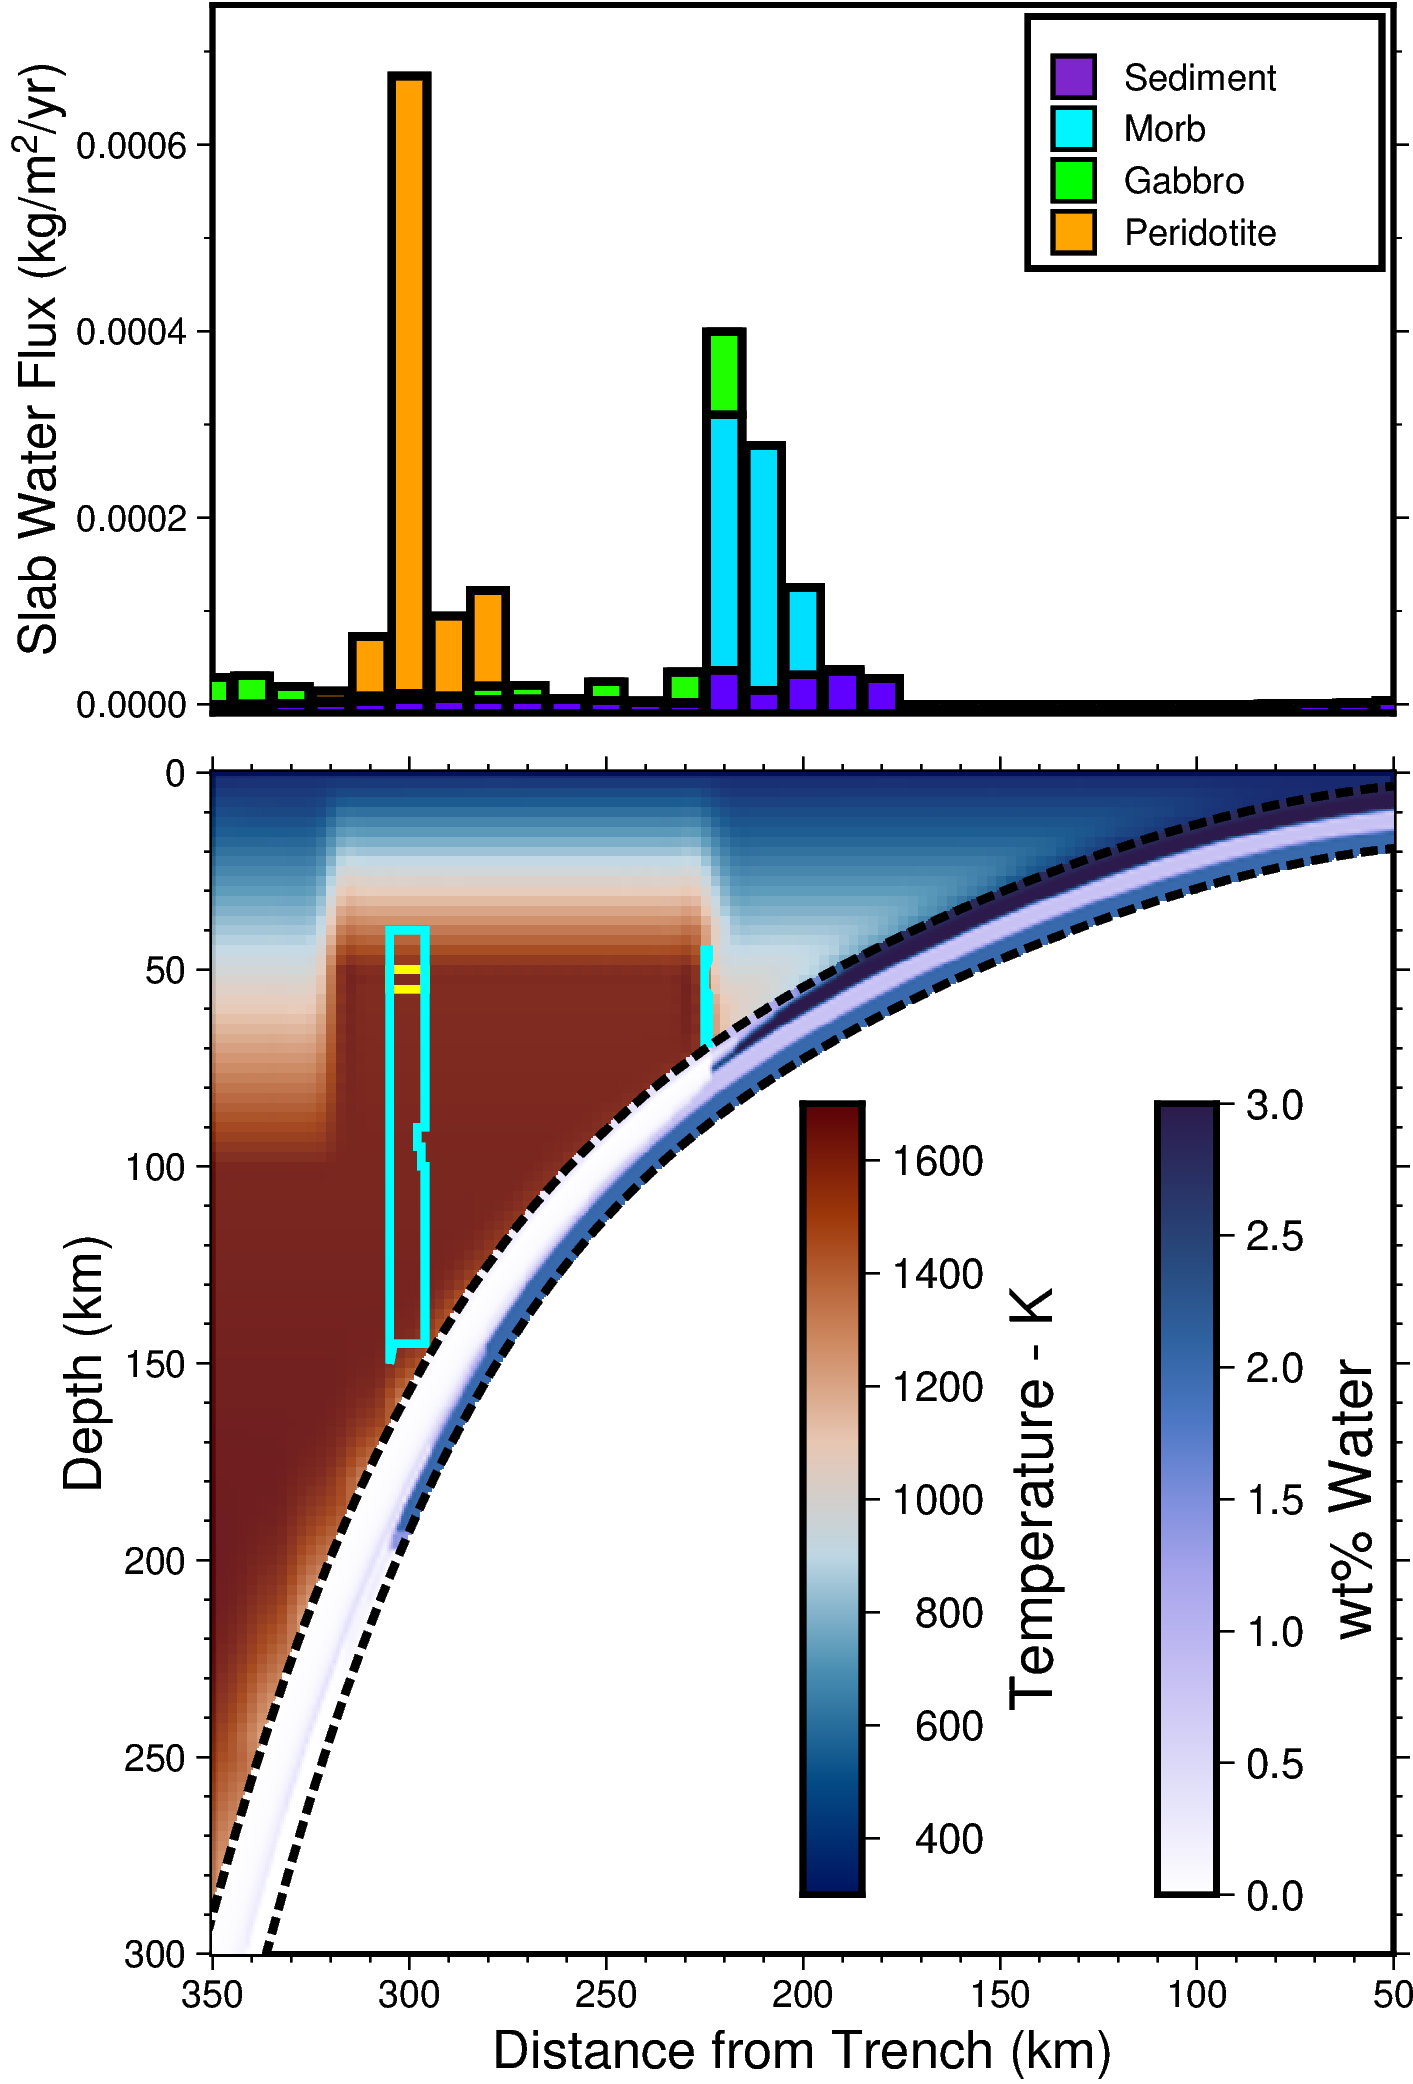

In [11]:
fig = pygmt.Figure()
fig.basemap(region=[50, 350, 0, 300], projection='X-10/-10', frame=["WStne", "xaf+lDistance from Trench (km)", "yaf+lDepth (km)"])
pygmt.makecpt(cmap="vik", series=[300, 1700, 200], continuous=True, reverse=False)
fig.grdimage(grid=TEMP_GRID, nan_transparent=True, transparency=10)
fig.colorbar(position="jBL+o5c/0.5c+w6.7c/0.5c+v", box=False, frame=["xa200f200+lTemperature - K"])

flux_convert =  10e3 / 0.05

pygmt.makecpt(cmap="devon", series=[0, 3.0, 0.3], continuous=True, reverse=True)
fig.grdimage(grid=SLAB_GRID, nan_transparent=True)
fig.colorbar(position="jBL+o8c/0.5c+w6.7c/0.5c+v", box=False, frame=["xa0.5f0.5+lwt% Water"])
fig.contour(x=UM_slab_top_dist, y=UM_slab_top_depth, z=P_solidus_fast, pen="2p,yellow1", annotation="n", levels=1)
fig.contour(x=UM_slab_top_dist, y=UM_slab_top_depth, z=P_solidus_slow, pen="2p,cyan1", annotation="n", levels=1)
fig.plot(x=parallel_slab_dist[0], y=parallel_slab_depth[0], pen='2p,black,4_2:2p')
fig.plot(x=parallel_slab_dist[-1], y=parallel_slab_depth[-1], pen='2p,black,4_2:2p')

fig.shift_origin(yshift="h+0.5c")
bin_sediment_slab_flux[np.where(bin_sediment_slab_flux < 0)] = 0
bin_MORB_slab_flux[np.where(bin_MORB_slab_flux < 0)] = 0
bin_gabbro_slab_flux[np.where(bin_gabbro_slab_flux < 0)] = 0
bin_peridotite_slab_flux[np.where(bin_peridotite_slab_flux < 0)] = 0

pygmt.makecpt(cmap="rainbow", series=[0, 4, 1])

data = {
    "y": surface_slab_flux_x,
    "x1": bin_sediment_slab_flux / flux_convert,
    "x2": bin_MORB_slab_flux / flux_convert,
    "x3": bin_gabbro_slab_flux / flux_convert,
    "x4": bin_peridotite_slab_flux / flux_convert
}

fig.basemap(region=[50, 350, -0.00001, 0.00075], projection="X-10/6",
            frame=["yaf+lSlab Water Flux (kg/m@+2@+/yr)", "WSne+t"])
fig.plot(data=data, style="b0.3c+i4", cmap=True, pen="2p")

fig.plot(x=surface_slab_flux_x, y=bin_sediment_slab_flux + 10, \
         style='s0.5c', fill='purple3', pen='1p,black', label="Sediment+G0.2")

fig.plot(x=surface_slab_flux_x, y=bin_MORB_slab_flux + 10, \
         style='s0.5c', fill='turquoise1', pen='1p,black', label="Morb+G0.1")

fig.plot(x=surface_slab_flux_x, y=bin_gabbro_slab_flux + 10, \
         style='s0.5c', fill='green', pen='1p,black', label="Gabbro+G0.1")

fig.plot(x=surface_slab_flux_x, y=bin_peridotite_slab_flux + 10, \
         style='s0.5c', fill='orange', pen='1p,black', label="Peridotite+G0.1")

fig.legend(position="jTR+o0.1c+w3c", box=True)

fig.savefig("melting-regions.png") 
fig.show()